# 🌠Premable🌠

In [1]:
import ugradio
import threading
from astropy.io import fits
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import time
import scipy
import astropy
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker


from scipy.signal import stft
from scipy.signal import argrelextrema as get_extrema_indices

#%matplotlib notebook
%matplotlib inline

No module named 'rtlsdr'


In [2]:
#Need hour angle! Let's write code for that really quick. I have to pee. 
def get_ha(unix_time):
    jd = ugradio.timing.julian_date(unix_time)
    lst_rad = ugradio.timing.lst(jd=jd)
    ra_deg, dec_deg = ugradio.coord.sunpos(jd=jd)
    dec_rad = np.deg2rad(dec_deg)
    ra_rad = np.deg2rad(ra_deg)
    ha_rad = lst_rad - ra_rad
    #if ha_rad is less than -pi, add 2pi
    if ha_rad < -np.pi:
        ha_rad += 2 * np.pi
    return dec_rad, ra_rad, ha_rad  

# 🌠Loading in Data🌠

In [3]:
def data_blob(filename):
    with fits.open(filename) as f:
        vals = []
        for i in range(1,len(f)):
            data = f[i].data
            tab = Table(data)
            vals += [tab[i].data for i in tab.columns]
    return np.array(vals)

In [4]:
#Load in that data boi. Mashallah. Thank you Claire, I stole this from you. I am learning. 
filename_1 = "/Users/sumbal/Desktop/Coding/Sun_HtoH/htohsunactual.fits"
filename_2 = "/Users/sumbal/Desktop/Coding/Sun_HtoH/htohsunactual_p2.fits"
filename_3 = "/Users/sumbal/Desktop/Coding/Sun_HtoH/htohsunactual_p3.fits"

#Have to organize her or else she will die, Astaghfirullah. Will delete first two data point from 
#each set because they are haram. 
sun_data_1 = data_blob(filename_1)[2:]
sun_data_2 = data_blob(filename_2)[2:]
sun_data_3 = data_blob(filename_3)[2:]
print(sun_data_1.shape)
print(sun_data_2.shape)
print(sun_data_3.shape)

(15248, 1024)
(12898, 1024)
(898, 1024)


In [5]:
#There is so much data, so much sun, yipEEEee!
#So lets combine our THREE THICK BOI FILES of sun data into ✨ONE THICKK BOI✨. Mashallah

sun_hh_data = np.concatenate((sun_data_1, sun_data_2, sun_data_3), axis=0)
print(sun_hh_data.shape)

(29044, 1024)


In [6]:
#Now we must deal with the pains of time. She is all one array, so I must slice very VERY carefully. 
#I sound like Hannibal Lecter

unix_times = np.load('times.npz')['data']
unix_times = sorted(unix_times) #Must do this because the times for the last data set were stiched to beginning. 

modified_unix_times = unix_times[2:15251] + unix_times[15253:28151] + unix_times[28153:]
modified_ha = np.array([get_ha(i)[2] for i in modified_unix_times])

unix_times_differences = np.diff(modified_unix_times)
avg_unix_times_difference = np.mean(unix_times_differences)

print('The average differnece between the unix times is {:0.4} seconds'.format(avg_unix_times_difference))
print('The length of the modified unix times array is {}'.format(len(modified_unix_times)))

The average differnece between the unix times is 1.267 seconds
The length of the modified unix times array is 29044


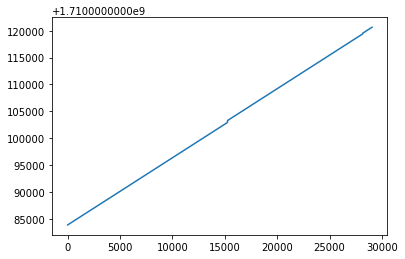

In [7]:
#Just me plotting the unix times. We see two jumps, corrosponding to each time when the snap died for us.
fig, ax = plt.subplots(1,1)
ax.plot(unix_times)

In [8]:
#Beautiful. Now that we have the times for each channel, 
#let's shift to getting the frequency corrosponding to each channel. Thank's Claire, I stole this from you.

snap_freqs = np.linspace(0, 250e6, 1024, endpoint=False)
LO1 = 8.75e9 # Hz
LO2 = 1.55e9 # Hz
channel_freqs = snap_freqs + LO1 + LO2
frequency_channel660 = channel_freqs[660]  #Now finding the frequency of the channel we will be using (look at next cell), channel 660
C = astropy.constants.c.value
lam_channel660 = C / frequency_channel660 # wavelength in meters
lat_deg = ugradio.nch.lat
lat = np.deg2rad(lat_deg)

print("The frecuency corrosponding to the channel we are looking at is {:.2e} Hz and the wavelength is {:.3} meters".format(frequency_channel660, lam_channel660))


The frecuency corrosponding to the channel we are looking at is 1.05e+10 Hz and the wavelength is 0.0287 meters


# 🌠Waterfall Plots🌠

In [9]:
#times and data called above
ones = np.ones(shape=(len(sun_hh_data),1))

real_mean = np.mean(sun_hh_data.real, axis=0)[np.newaxis,:]
real_corrections = np.matmul(ones, real_mean)
real_phase_corrected = sun_hh_data.real - real_corrections


imag_mean = np.mean(sun_hh_data.imag, axis=0)[np.newaxis, :]
imag_corrections = np.matmul(ones, imag_mean)
imag_phase_corrected = sun_hh_data.imag - imag_corrections

corrected_data = real_phase_corrected + 1j * imag_phase_corrected



#corrected_data = phase_corrected +1j*sun_hh_data.imag


In [10]:
#times and data called above
mean = np.mean(sun_hh_data.real, axis=0)[np.newaxis,:]
ones = np.ones(shape=(len(sun_hh_data),1))
corrections = np.matmul(ones,mean)
phase_corrected = sun_hh_data.real-corrections

corrected_data = phase_corrected +1j*sun_hh_data.imag

# Create a list of hour angles with three decimal places. This i sfor plotting the waterfall bois nicely. yeetetetetetet. 
modified_ha_formatted = ['{:.2f}'.format(angle) for angle in modified_ha]
channel_freqs_formatted = ['{:.2f}'.format(freq/10**9) for freq in channel_freqs]

In [11]:
np.shape(corrected_data)

(29044, 1024)

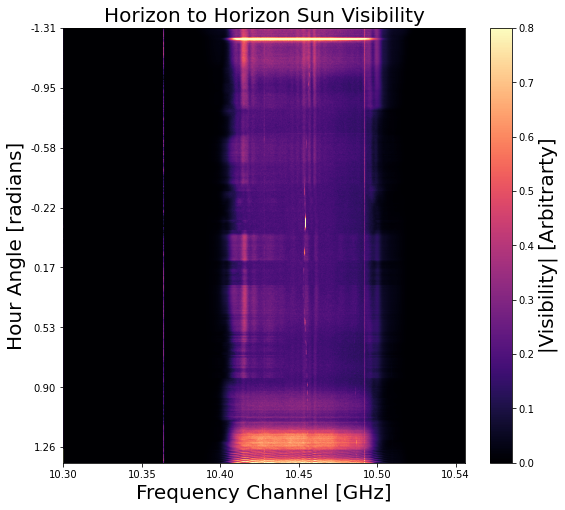

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
im = ax.imshow(np.abs(corrected_data), vmin=0, vmax=0.8, cmap='magma', aspect='auto')
cbar = fig.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label('|Visibility| [Arbitrarty]', fontsize=20)
ax.set_title('Horizon to Horizon Sun Visibility', fontsize=20)
ax.set_xlabel('Frequency Channel [GHz]', fontsize=20)
ax.set_ylabel('Hour Angle [radians]', fontsize=20)

ax.set_yticks(np.arange(0, len(modified_ha), 4000))  # Adjust ticks for better readability
ax.set_yticklabels(modified_ha_formatted[::4000])

ax.set_xticks(np.arange(0, len(channel_freqs_formatted), 200))  # Adjust ticks for better readability
ax.set_xticklabels(channel_freqs_formatted[::200])

plt.show()


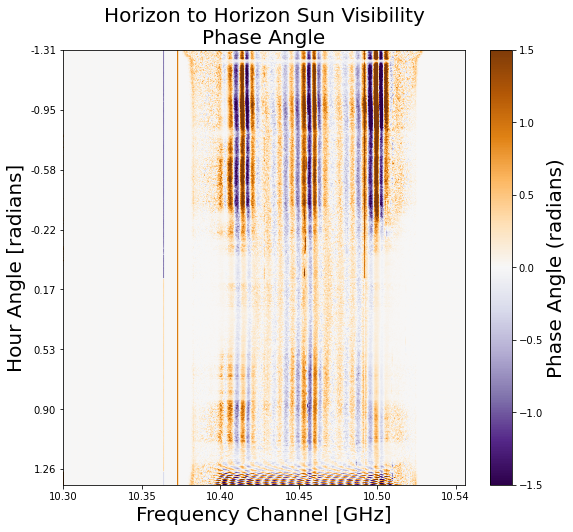

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
im = ax.imshow(np.angle(corrected_data), cmap='PuOr_r', aspect='auto', vmin=-1.5, vmax=1.5)
cbar = fig.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label('Phase Angle (radians)', fontsize=20)
ax.set_title('Horizon to Horizon Sun Visibility\nPhase Angle', fontsize=20)
ax.set_xlabel('Frequency Channel [GHz]', fontsize=20)
ax.set_ylabel('Hour Angle [radians]', fontsize=20)


ax.set_yticks(np.arange(0, len(modified_ha), 4000))  # Adjust ticks for better readability
ax.set_yticklabels(modified_ha_formatted[::4000])

ax.set_xticks(np.arange(0, len(channel_freqs_formatted), 200))  # Adjust ticks for better readability
ax.set_xticklabels(channel_freqs_formatted[::200])

plt.show()


In [14]:
freqs_tau = np.fft.fftshift(np.fft.fft(corrected_data, axis = 1), axes = [1])
boi = np.abs(freqs_tau)

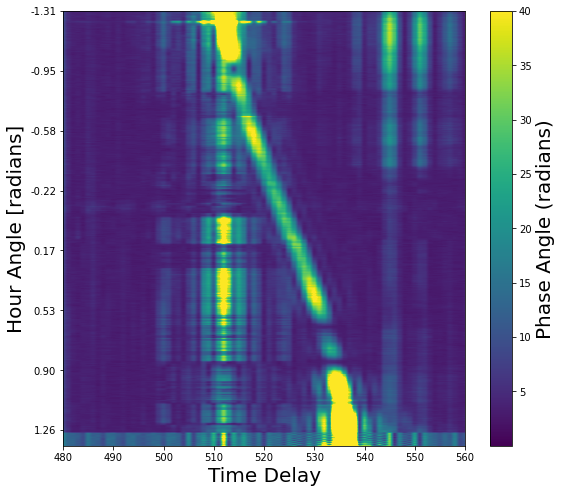

In [15]:
#THIS IS SUS AS HECK. Maybe... don't...
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
im = ax.imshow(boi, cmap='viridis', aspect='auto', vmax = 40)
cbar = fig.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label('Phase Angle (radians)', fontsize=20)
#ax.set_title('Horizon to Horizon Sun Visibility\nPhase Angle', fontsize=20)
ax.set_xlabel('Time Delay', fontsize=20)
ax.set_ylabel('Hour Angle [radians]', fontsize=20)
ax.set_xlim(480,560)

ax.set_yticks(np.arange(0, len(modified_ha), 4000))  # Adjust ticks for better readability
ax.set_yticklabels(modified_ha_formatted[::4000])

#ax.set_xticks(np.arange(0, len(channel_freqs_formatted), 200))  # Adjust ticks for better readability
#ax.set_xticklabels(channel_freqs_formatted[::200])

plt.show()


# 🌠Time to Cook🌠

In [16]:
#Let's get the channel values I want to work with. I am not a master,
#so going to work at channel 660 becase I think it plotted the least awfully.

visibility_1channel_oiginal = sun_hh_data[0:, 660] 
visibility_1channel = visibility_1channel_oiginal-np.mean(visibility_1channel_oiginal) #This one has mean subtracted! Note, it means both the imaginary and real part for us! So cute!
visibility_1channel.shape

(29044,)

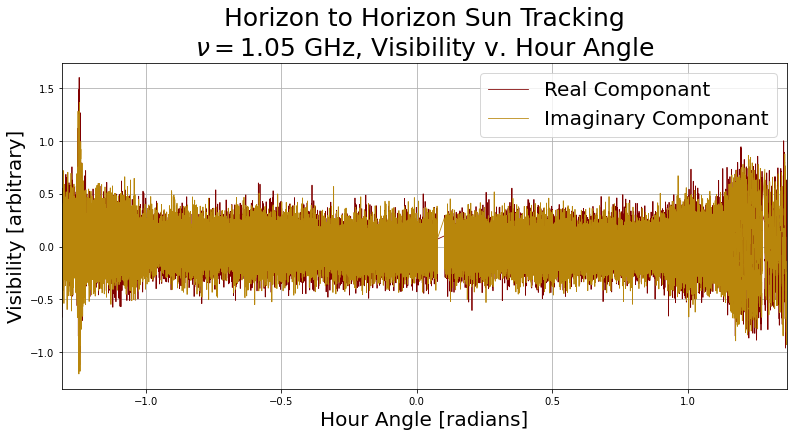

In [17]:
fig, ax = plt.subplots(1,1,figsize = (13,6))

ax.plot(modified_ha, visibility_1channel.real, linewidth = 0.8,label = 'Real Componant', color = 'maroon')
ax.plot(modified_ha, visibility_1channel.imag, linewidth = 0.8,label = 'Imaginary Componant', color = 'darkgoldenrod')

ax.set_xlim(min(modified_ha),max(modified_ha))

ax.set_xlabel('Hour Angle [radians]', size = 20)
ax.set_ylabel('Visibility [arbitrary]', size = 20)
ax.set_title(r'Horizon to Horizon Sun Tracking'+ '\n' + r'$\nu=1.05$ GHz, Visibility v. Hour Angle', size = 25)

plt.grid()
plt.legend(fontsize = 20)
plt.savefig('SumbalHtoH.jpeg', bbox_inches='tight')

plt.show()

In [18]:
fringe_freq, t_ind, data_f = scipy.signal.stft(visibility_1channel, window='boxcar',
                                              fs=1/avg_unix_times_difference, nperseg=512, 
                                              axis=0, return_onesided=False)

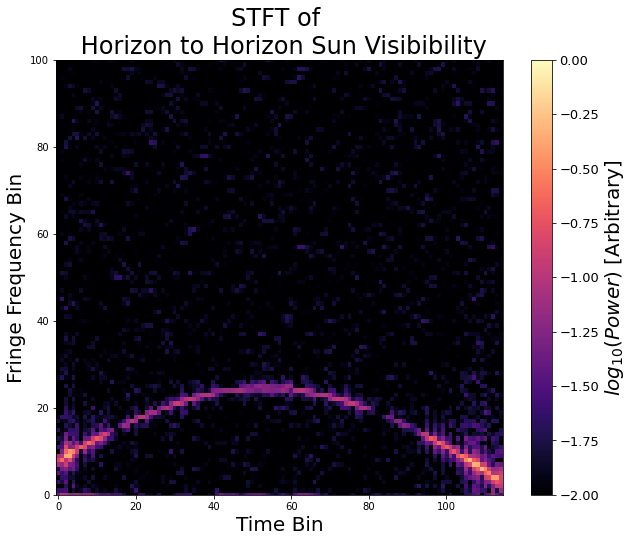

In [19]:
fig, ax = plt.subplots(figsize = (10,8))
img = ax.imshow(np.log10(np.abs(data_f)), aspect='auto', interpolation='nearest', cmap='magma', 
                vmin=-2, vmax=0)
ax.set_ylim(0,100)
cbar = fig.colorbar(img)
cbar.set_label(label=r'$log_{10}(Power)$ [Arbitrary]', fontsize = 20)
cbar.ax.tick_params(labelsize=13)

plt.xlabel(f'Time Bin', fontsize=20)
plt.ylabel(f'Fringe Frequency Bin', fontsize=20)
plt.title(f'STFT of \n Horizon to Horizon Sun Visibibility', fontsize=24)

plt.savefig('SumbalSTFT.jpeg', bbox_inches='tight')

plt.show()

In [20]:
#The above is beautiful, but it is not quite what we need. We need to extract the bright hill. 
#That is what we will fit to in order to find the baselines. That is the fringe frequency curve of our sun.

#find the frequency at which the power is maximized, for each time bin. How we will construct hill.
#Thank you Claire, I stole this ALL form you. <3
power_data = np.abs(data_f)**2
fringe_freq_curve = np.array([])
for i in np.arange(0, len(t_ind)):
    power = power_data[:, i]
    max_idx = np.where(power == np.max(power))[0][0]
    if (max_idx == 0):
        max_idx = np.where(power[1:] == np.max(power[1:]))[0][0]
        fringe_freq_curve = np.append(fringe_freq_curve, fringe_freq[1:][max_idx])     
    else:
        fringe_freq_curve = np.append(fringe_freq_curve, fringe_freq[max_idx])

In [21]:
#Now to transform the unix times we have to hour angle (Again, lol, just to keep things clean for ourselves). 
#Que magical girl transformation music. YAY!
stft_times = modified_unix_times[0] + t_ind
ras_radians = np.array([get_ha(i)[0] for i in stft_times])
declinations_radians = np.array([get_ha(i)[1] for i in stft_times])
hour_angles = np.array([get_ha(i)[2] for i in stft_times])

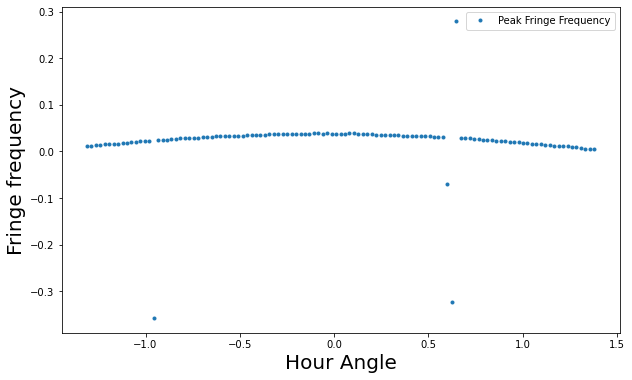

In [22]:
#plot the times vs. frequencies in fringe_freq_curve
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(hour_angles, fringe_freq_curve, '.',label='Peak Fringe Frequency')
ax.set_xlabel('Hour Angle', size = 20)
ax.set_ylabel('Fringe frequency', size = 20)
plt.legend()
plt.show()

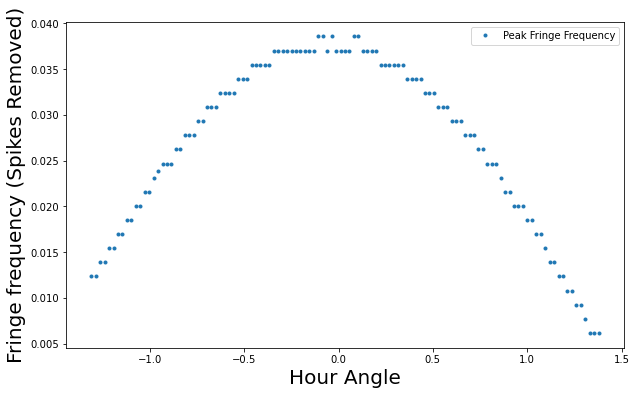

In [23]:
#for points with significant jumps in fringe freq, 
#set them to the average of the value right before and right after

#Considerign only the first jump on the left of the graph. Only Spans one point, so easy to deal with.
for i in np.arange(1, len(fringe_freq_curve)-50):
    if (np.abs(fringe_freq_curve[i] - fringe_freq_curve[i-1]) > 0.02):
        fringe_freq_curve[i] = (fringe_freq_curve[i-1] + fringe_freq_curve[i+1]) / 2
        
#Considerign the jump(s) on the right of the graph. Spans three points, so let's accomodate to that. 
for i in np.arange(len(fringe_freq_curve)-50, len(fringe_freq_curve)):
    if (np.abs(fringe_freq_curve[i] - fringe_freq_curve[i-3]) > 0.05):
        fringe_freq_curve[i] = (fringe_freq_curve[i-3] + fringe_freq_curve[i+3]) / 2
        
#plot the times vs. frequencies in fringe_freq_curve
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(hour_angles, fringe_freq_curve, '.',label='Peak Fringe Frequency')
ax.set_xlabel('Hour Angle', size = 20)
ax.set_ylabel('Fringe frequency (Spikes Removed)', size = 20)
plt.legend()
plt.show()

# 🌠E/W and N/S Baselines Time🌠

In [24]:
#First got to define that chi squared stuff since we are fitting and such now. 
def chi2(data, model, err):
    return np.sum((data-model)**2/err**2)

def reduced_chi2(data, model, err):
    n = len(data)
    return chi2(data, model, err)/(n-1)

In [25]:
#Now we got to define that fringe frequency fit that Bassoon put on board. 

def fringe_frequency(b_ew, b_ns, lam, dec, ha, lat = np.deg2rad(ugradio.nch.lat)):
    sidereal_day = 86164.1 # seconds
    omega_earth = 2 * np.pi / sidereal_day
    ew = (b_ew / lam) * np.cos(dec) * np.cos(ha)
    ns = (b_ns / lam) * np.sin(lat) * np.cos(dec) * np.sin(ha)
    f = omega_earth * (ew - ns)
    return f

In [26]:
#for each east-west and north-south baseline, calculate the fringe frequency over the full time array
#then find the chi-squared of the data with the model
#then store that chi-squared value in a 2D array with the east-west and north-south baseline values used

num_b_ew = 1000
num_b_ns = 1000
b_ew = np.linspace(12, 19, num_b_ew)
b_ns = np.linspace(0, 5, num_b_ns)
chi2_values = np.zeros((num_b_ew, num_b_ns))
chi2_reduced_values = np.zeros((num_b_ew, num_b_ns))
err_guess = 0.0005
#err_guess = 0.0003

measured = fringe_freq_curve

#dictionary to store each model: key is the baseline combination, value is the model
models = {}

for i in range(num_b_ew):
    for j in range(num_b_ns):
        model = fringe_frequency(b_ew[i], b_ns[j], lam_channel660, declinations_radians, hour_angles)
        chi2_values[i, j] = chi2(measured, model, err_guess)
        chi2_reduced_values[i, j] = reduced_chi2(measured, model, err_guess)
        #add the model and its baseline values to the dictionary
        models[(b_ew[i], b_ns[j])] = model

In [27]:
#Now lets find out minimum boi (the smolest χ^2 value). #babybabybabybabybabybabybabygirlbehavior
min_chi2 = np.min(chi2_values)
min_chi2_idx = np.where(chi2_values == min_chi2)
min_b_ew = b_ew[min_chi2_idx[0][0]]
min_b_ns = b_ns[min_chi2_idx[1][0]]

HOLD ON YOU'RE NOT READY TO PLOT YET, HOLD YOUR HORSES MAN. Got to get error on the boi. Oof I stole this from Charlie, thank you Charlie, I love you. <3

$\chi^2 <= \chi^2_{min} + N_{sig}^2$ 


"Where $N_{sig}$ is 1, 2, 3 etc. depending what you want your sigma to be. I chose 2 because 3 is too many sigma. We don't have to add a $\sigma$ because the $\chi^2$ takes the error guess into account already. Then we filter our ns and ew values by the chi square values we care about, and get upper and lower bounds within $2\sigma$ for both." - Charlie

In [28]:
#Find a standard error in frequency time space
#take an empty patch of the stft space, find the standard deviation of it
data_for_error = np.abs(data_f)
data_for_error = data_for_error[10:]
mean = np.mean(data_for_error)
sig = np.std(data_for_error)

#lets use two sigma, it's decent
chi2_up_bound = min_chi2 + 4
chi2_low_bound = min_chi2 - 4

xbound, ybound = np.where((chi2_values > chi2_low_bound) & (chi2_values < chi2_up_bound))
nsmins, ewmins = b_ns[ybound], b_ew[xbound]
nslow, nshigh = np.min(nsmins), np.max(nsmins)
ewlow, ewhigh = np.min(ewmins), np.max(ewmins)
nsmin, ewmin = b_ns[min_chi2_idx[1]], b_ew[min_chi2_idx[0]]

print(nsmin-nslow, nshigh-nsmin)
print(ewmin-ewlow, ewhigh-ewmin)
print(ewmin, nsmin)

[0.09009009] [0.09009009]
[0.04204204] [0.04904905]
[14.99199199] [1.34134134]


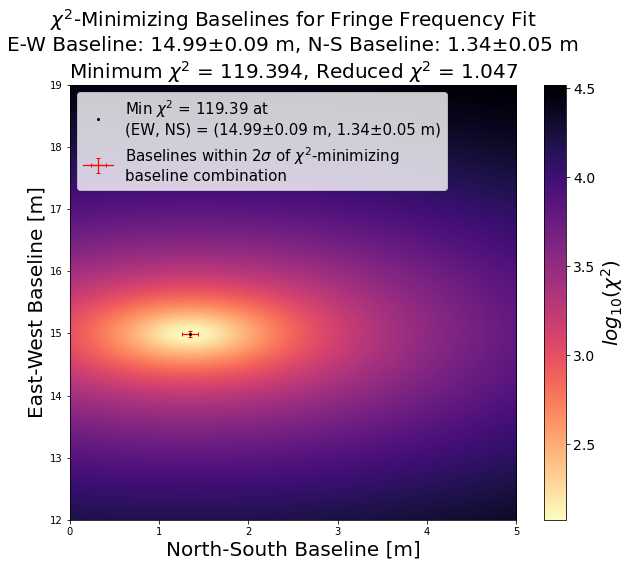

In [29]:
fig, ax = plt.subplots(figsize = (10,8))
img = ax.imshow(np.log10(chi2_values), extent=(b_ns[0], b_ns[-1], b_ew[0], b_ew[-1]), 
           origin='lower', aspect='auto', interpolation='nearest', cmap='magma_r')

ax.plot(b_ns[min_chi2_idx[1]], b_ew[min_chi2_idx[0]], 'ko', markersize=2, label=r'Min $\chi^2$' + f' = {min_chi2:.2f} at \n(EW, NS) = ({b_ew[min_chi2_idx[0][0]]:.2f}±0.09 m, {b_ns[min_chi2_idx[1][0]]:.2f}±0.05 m)', zorder = 70)
ax.errorbar(float(b_ns[min_chi2_idx[1]]), float(b_ew[min_chi2_idx[0]]), xerr=0.09, yerr=0.05, 
            linewidth = 1.2, color = 'red', capsize=2, marker='.', markersize=0, markerfacecolor='black', zorder = 6, label = r'Baselines within $2\sigma$ of $\chi^2$-minimizing' + '\n' +'baseline combination')

#plt.scatter(b_ns[ybound], b_ew[xbound], color='red', alpha = 0.2)

cbar = fig.colorbar(img)
cbar.set_label(label=r'$log_{10}(χ^2)$', fontsize = 20)

cbar.ax.tick_params(labelsize=14)
ax.set_xlabel('North-South Baseline [m]', size = 20)
ax.set_ylabel('East-West Baseline [m]', size = 20)
ax.set_title(r'$\chi^2$-Minimizing Baselines for Fringe Frequency Fit' + '\n' + f'E-W Baseline: {min_b_ew:.2f}±0.09 m, N-S Baseline: {min_b_ns:.2f}±0.05 m\n' + f'Minimum $\chi^2$ = {min_chi2:.3f}, Reduced $\chi^2$ = {reduced_chi2(measured, models[(min_b_ew, min_b_ns)], err_guess):.3f}', size = 20)

plt.legend(fontsize = 15, loc = 'upper left')
plt.savefig('SumbalBruteForce.jpeg', bbox_inches='tight')

plt.show()

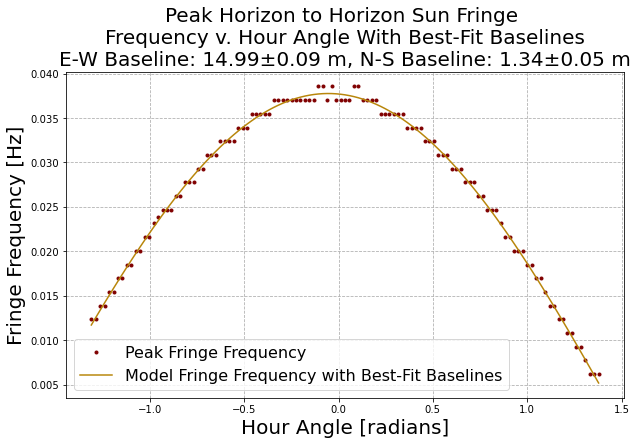

In [30]:
#Omg, so cool! Now let's compare!

#let's compare!!!!

fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(hour_angles, fringe_freq_curve, '.',label='Peak Fringe Frequency', color = 'maroon')
ax.plot(hour_angles, fringe_frequency(min_b_ew, min_b_ns, lam_channel660, declinations_radians, hour_angles), label=f'Model Fringe Frequency with Best-Fit Baselines', color = 'darkgoldenrod')


ax.set_xlabel('Hour Angle [radians]', size = 20)
ax.set_ylabel('Fringe Frequency [Hz]', size = 20)
plt.title(f'Peak Horizon to Horizon Sun Fringe \nFrequency v. Hour Angle With Best-Fit Baselines\nE-W Baseline: {min_b_ew:.2f}±0.09 m, N-S Baseline: {min_b_ns:.2f}±0.05 m', size = 20)

plt.legend(fontsize = 16)
ax.grid(linestyle = '--')
plt.savefig('SumbalBaselineFit.jpeg', bbox_inches='tight')

plt.show()


# 🌠Bessel Time🌠

In [31]:
#I need a way to extract the envelope of the data. So I will use the code I copied from a guy on YouTube. Thank you, Gu 
#Okay wait, I actually ended up NOT usign this. LOL! I will keep it here for safekeepign though for future (mayhaps)

'''
def signal_envelope(signal, frame_size, hop_length = 1):
    amplitude_envelope = []
    
    #Calculating the Amplitude envelope for each frame, yipeee!
    for i in range(0, len(signal), hop_length):
        current_frame_amplitude_envelope = max(signal[i:i+frame_size])
        amplitude_envelope.append(current_frame_amplitude_envelope)
        
    return np.array(amplitude_envelope)

#Note, for genreal use, frame_size should be larger than 
'''

'\ndef signal_envelope(signal, frame_size, hop_length = 1):\n    amplitude_envelope = []\n    \n    #Calculating the Amplitude envelope for each frame, yipeee!\n    for i in range(0, len(signal), hop_length):\n        current_frame_amplitude_envelope = max(signal[i:i+frame_size])\n        amplitude_envelope.append(current_frame_amplitude_envelope)\n        \n    return np.array(amplitude_envelope)\n\n#Note, for genreal use, frame_size should be larger than \n'

In [32]:
#To Bessel the boi, we must import a think. Why? 
#Because my 19 year old self was cooking when I did this in the past and I like reusing recipies. Alhamdulillah.

from scipy.signal import argrelextrema as get_extrema_indices

<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 32, 35, 38, 41, 44, 47]),)


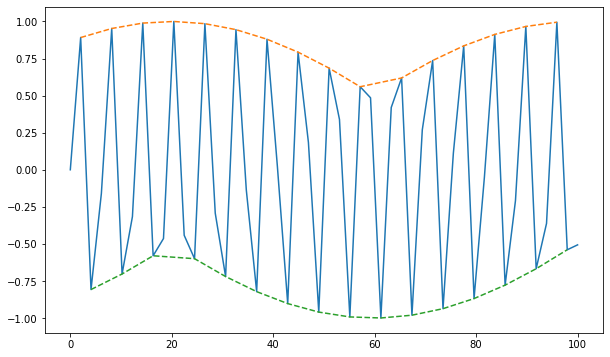

In [33]:
#Wait, I am a little dumb and need to remeber how it worked. Let me so some simulated waveform first

#Simulated data
simulated_x = np.linspace(0,100,50)
simulated_y = np.sin(simulated_x)

neighborhood_size = 2
max_indices = get_extrema_indices(simulated_y, np.greater, order=neighborhood_size)
min_indices = get_extrema_indices(simulated_y, np.less, order=neighborhood_size)
print(type(max_indices))
print(type(simulated_y))
print(type(simulated_y[max_indices]))
print(type(simulated_x))
print(type(simulated_x[max_indices]))
print(max_indices)

fig, ax = plt.subplots(1,1,figsize = (10,6))
ax.plot(simulated_x, simulated_y)
ax.plot(simulated_x[max_indices], simulated_y[max_indices], linestyle = "--")
ax.plot(simulated_x[min_indices], simulated_y[min_indices], linestyle = "--")

#ax.plot(simulated_envelope, linestyle = '--', marker = '.')
#Okay, I remember now. Slaey. 

In [34]:
#Our data is kind of ugly, so we need to slice part where Bessel function exists according to my eyeballs
#Note, I chose the sunset part. I got the values to slice by just looking over the previous horizon to horizon part, Yipeee!
bessel_sample = visibility_1channel_oiginal[20570:28500]
bessel_sample = np.abs(bessel_sample)
bessel_sample = bessel_sample - np.mean(bessel_sample)

neighborhood_size = 20
unix_time_sample = np.array(modified_unix_times[20570:28500])
max_indices = get_extrema_indices(bessel_sample, np.greater, order=neighborhood_size)

print(type(unix_time_sample))
print(type(bessel_sample))
print(type(max_indices))
bessel_sample_envelope_times = unix_time_sample[max_indices]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'tuple'>


In [35]:
#Now to transform the unix times we have to hour angle. Cue magical girl transformation music. YAY!
ha = np.array([get_ha(i)[2] for i in unix_time_sample])

In [36]:
#u_mag is with w included... but I will NOT do it this way.

u_mag = np.sqrt(np.abs((min_b_ew**2 + min_b_ns**2 / lam_channel660**2) - ((min_b_ew + min_b_ns)/lam_channel660)**2))
print(u_mag)

#u_max is without w and instead serves as the amplitude, and w kind of basically serves as 
#cos(hour angle) which you will see in the next cell. 
#Better in my opinion since it seems easier to use. 
u_max = np.sqrt(min_b_ew**2 + min_b_ns**2) / lam_channel660
print(u_max)

567.8218203964933
525.2289938091171


# The Bessel fit we shall use is $\alpha \left( \frac{\left| J_1 \left( 2 \pi u_{\text{max}} \cos(h) r_{\odot} \right) \right|}{2 \pi u_{\text{max}} \cos(h) r_{\odot}} \right) + \beta$ where $u_{\text{max}} = \frac{| b |}{\lambda} = \frac{\sqrt{b_{ew}^2 + b_{ns}^2}}{\lambda}$

In [37]:
#Okay, now to write out bessle function appriximation function. WOW! Beauiful. Thank you, Mallory. 
def bessel(h, A, b, r):
    return A * (np.abs(scipy.special.j1(2 * np.pi * u_max * np.cos(h) * r) / (2 * np.pi * u_max * np.cos(h) * r))) + b

guess = np.array([20, 1, 0.004])
bessel_opt, bessel_cov = curve_fit(bessel, ha[max_indices], bessel_sample[max_indices], p0 = guess)
bessel_std_errs = np.sqrt(np.diag(bessel_cov))

#Finding that Chi ssqaured stuff. Got to assess that fit. Slaey. 
bessel_chi2 = chi2(bessel_sample[max_indices], bessel(ha[max_indices], *bessel_opt), bessel(ha[max_indices], *bessel_opt)-bessel_sample[max_indices])
bessel_rediced_chi2 = reduced_chi2 (bessel_sample[max_indices], bessel(ha[max_indices], *bessel_opt), bessel(ha[max_indices], *bessel_opt)-bessel_sample[max_indices])

In [38]:
bessel_std_errs

array([4.37823072e-01, 1.12907160e-02, 1.94828945e-05])

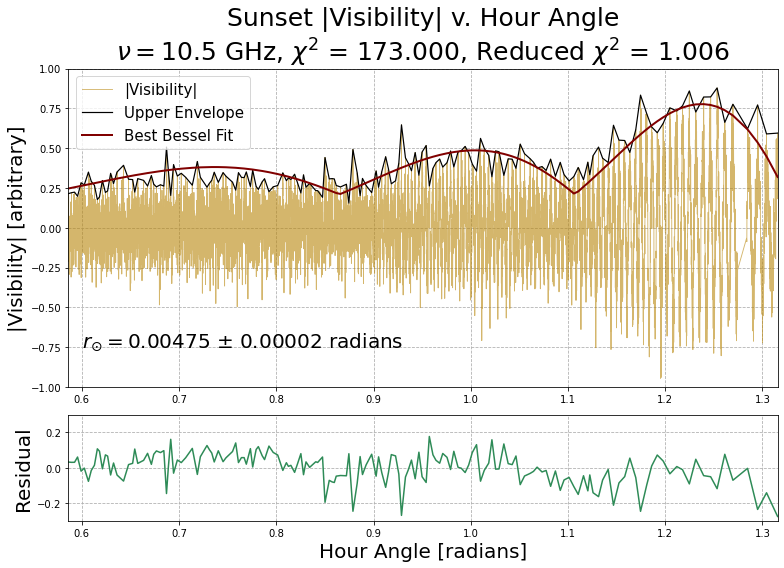

In [39]:
%matplotlib inline
#Now to plot that boi. This is the moment we have been waiting for
fig, ax = plt.subplots(2,1,figsize = (11,8), gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(ha, bessel_sample, linewidth = 0.9, alpha = 0.6, color = "darkgoldenrod",label = '|Visibility|')
ax[0].plot(ha[max_indices], bessel_sample[max_indices], linewidth = 1.2,linestyle = "-", color = 'black', label = "Upper Envelope")
ax[0].plot(ha[max_indices], bessel(ha[max_indices], *bessel_opt), linewidth = 2,linestyle = "-", color = "maroon", label = "Best Bessel Fit")
ax[0].text(0.6, -0.75, r'$r_{{\odot}} = {:0.3}$ ± 0.00002 radians'.format(bessel_opt[2]), size = 20)

ax[0].set_xlim(min(ha[max_indices]), max(ha[max_indices]))
ax[0].set_ylim(-1, 1)

ax[0].set_ylabel('|Visibility| [arbitrary]', size = 20)
ax[0].set_title(r'Sunset |Visibility| v. Hour Angle' + '\n' + f'$\\nu = 10.5$ GHz, $\chi^2$ = {bessel_chi2:.3f}, Reduced $\chi^2$ = {bessel_rediced_chi2:.3f}', size = 25)

ax[0].grid(linestyle = '--')
ax[0].legend(fontsize = 15, loc = 'upper left')

ax[1].plot(ha[max_indices], bessel(ha[max_indices], *bessel_opt)-bessel_sample[max_indices], color = 'seagreen')
ax[1].set_xlabel('Hour Angle [radians]', size = 20)
ax[1].set_ylabel('Residual', size = 20)
ax[1].set_xlim(min(ha[max_indices]), max(ha[max_indices]))
ax[1].set_ylim(-0.3, 0.3)


ax[1].grid(linestyle = '--')

plt.tight_layout()
plt.savefig('SumbalBessel.jpeg', bbox_inches='tight')

plt.show()

In [40]:
np.rad2deg(0.00475)

0.272154952687141

In [41]:
np.rad2deg(0.00002)

0.0011459155902616466

# $r_{\odot}=0.272˚±0.01˚$

# 🌠Do Not Look Beyond: It is Forbidden by ALLAH🌠

In [ ]:
unix_times_differences = []
for i in range(len(unix_times) - 1):
    if dif > 1:
        dif = unix_times[i+1] - unix_times[i]
    if dif < 1:
        dif = unix_times[i] - unix_times[i-1]
    unix_times_differences.append(dif)
    
#print(unix_times_differences[897])
avg_unix_times_difference = np.mean(unix_times_differences)

print(avg_unix_times_difference)
print(len(unix_times))

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (14,7))
ax.plot(sun_hh_data[660])

In [ ]:
#Now to plot horizon to horizon visibilities. YiPeEEEE!

fig, ax = plt.subplots(1,1,figsize = (13,6))

ax.plot(modified_ha, visibility_1channel.real - np.mean(visibility_1channel.real), linewidth = 0.8,label = 'Real Componant', color = 'maroon')
ax.plot(modified_ha, visibility_1channel.imag - np.mean(visibility_1channel.imag), linewidth = 0.8,label = 'Imaginary Componant', color = 'darkgoldenrod')

ax.set_xlim(min(modified_ha),max(modified_ha))

ax.set_xlabel('Hour Angle [radians]', size = 20)
ax.set_ylabel('Visibility [arbitrary]', size = 20)
ax.set_title(r'Horizon to Horizon Sun Tracking'+ '\n' + r'$\nu=1.05$ GHz, Visibility v. Hour Angle', size = 25)

plt.grid()
plt.legend(fontsize = 20)
plt.savefig('SumbalHtoH.jpeg', bbox_inches='tight')

plt.show()

In [ ]:
#for points with significant jumps in fringe freq, 
#set them to the average of the value right before and right after

#Considerign only the first jump on the left of the graph. Only Spans one point, so easy to deal with.
        
for i in np.arange(len(fringe_freq_curve)-50, len(fringe_freq_curve)):
    if (np.abs(fringe_freq_curve[i] - fringe_freq_curve[i-1]) > 0.05):
        fringe_freq_curve[i] = (fringe_freq_curve[i-1] + fringe_freq_curve[i+1]) / 2
        
#plot the times vs. frequencies in fringe_freq_curve
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(hour_angles, fringe_freq_curve, '.',label='Peak Fringe Frequency')
ax.set_xlabel('Hour Angle', size = 20)
ax.set_ylabel('Fringe frequency (Spikes Removed)', size = 20)
plt.legend()
plt.show()

In [ ]:
#Omg, so cool! Now let's compare!

#let's compare!!!!

fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.plot(hour_angles, fringe_freq_curve, '.',label='Peak Fringe Frequency', color = 'maroon')
ax.plot(hour_angles, fringe_frequency(min_b_ew, min_b_ns, lam_channel660, declinations_radians, hour_angles), label=f'Model Fringe Frequency with Best-Fit Baselines', color = 'darkgoldenrod')


ax.set_xlabel('Hour Angle [radians]', size = 20)
ax.set_ylabel('Fringe Frequency [Hz]', size = 20)
plt.title(f'Fringe Frequency v. Hour Angle With Best-Fit Baselines\nE-W Baseline: {min_b_ew:.2f}±0.09 m, N-S Baseline: {min_b_ns:.2f}±0.04 m', size = 20)

plt.legend(fontsize = 16)
ax.grid(linestyle = '--')
plt.savefig('SumbalBaselineFit.jpeg', bbox_inches='tight')

plt.show()
